In [1]:
import sys
sys.path.append("../")  # look one directory up for qca modules, TODO: make a package
from copy import copy
from qca import QCA, QCA_from_file, main_from_params_list
from states import make_state
from mpl_toolkits import mplot3d
from matplotlib import cm
from scipy.optimize import curve_fit
from os import makedirs
import matplotlib.pyplot as plt
import measures as ms
import numpy as np
from figures import colors, names, lettering, powerlaw_fit

%matplotlib inline

from matplotlib import rc
fontstyle = {
    "pdf.fonttype": 42,
    "text.usetex": True,
    "text.latex.preamble":r"\usepackage{amsfonts}",
    "font.family": "serif",
    "font.size": 9}
plt.rcParams.update(fontstyle)
rc('mathtext', default='regular')
rc("text", usetex=True)
der = r"/home/lhillber/documents/research/cellular_automata/qeca/qca/data/"

In [2]:
import qca
import core
import matrix
import measures
import figures
import networkviz
from importlib import reload
reload(qca)
reload(core)
reload(matrix)
reload(measures)
reload(figures)
reload(networkviz)
from qca import QCA, QCA_from_file, main_from_params_list
from states import make_state
from figures import lettering, names

In [3]:
params_template = dict(
              L=19,
              T=1000.0,
              dt=1.0,
              R=6,
              r=1,
              V="H",
              BC="1-00",
              IC="c3_f1",
              E=0.0,
              N=1,
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)

Hparams_template = dict(
              L=19,
              T=1000.0,
              dt=0.1,
              R=4,
              r=2,
              V="X",
              BC="1-0000",
              IC="c3_f0-2",
              E=0.0,
              N=1,
              totalistic=True,
              hamiltonian=True,
              trotter=True,
              symmetric=True)

In [4]:
Ls = list(np.arange(6, 20))
#Ls= list(np.arange(16, 20))
Rs = [6, 1, 14, 4, 26]
ICs = [("c3_f1", "c3_f0-2"), "R123"]
Qs = np.zeros((len(ICs), len(Rs), len(Ls)), dtype="object")
params_list = []

for ICi, IC in enumerate(ICs):
    for Ri, R in enumerate(Rs):
        for Li, L in enumerate(Ls):
            if R in (4, 26):
                params = copy(Hparams_template)
                ICj = 1        
            else:
                params = copy(params_template)
                ICj = 0
            if ICi == 0:
                IC = ICs[ICi][ICj]
            params["R"] = R
            params["L"] = L
            params["IC"] = IC
            params_list.append(params)

            Q = QCA(params, der=der)
            Qs[ICi, Ri, Li] = Q

## Network Measure Time Series

In [ ]:
reload(figures)
reload(qca)
from figures import colors
from qca import QCA
def network_measure_timeseries(QS, ICs, Rs, Li=-1, t0=2, order=1, axs=None):
    tight_layout = False
    if axs is None:
        fig, axs = plt.subplots(2,1, figsize=(8,5))
        tight_layout = True
    RC = 0
    RDY = 0
    for ICi, IC in enumerate(ICs):
        for Ri, R in enumerate(Rs):
            Q = Qs[ICi, Ri, Li]
            if IC[0] == "R":
                RC += Q.get_measure(f"P_{order}", save=True)[int(t0/Q.dt)::int(1/Q.dt)] / len(Rs)
                RDY += Q.get_measure(f"DY_{order}", save=True)[int(t0/Q.dt):-1:int(1/Q.dt)] / len(Rs)
            else:
                axs[0].plot(Q.ts[int(t0/Q.dt):], Q.get_measure("P_1", save=True)[int(t0/Q.dt):], c=colors[R], lw=1)

                axs[1].plot(Q.ts[int(t0/Q.dt):1-int(Q.L/Q.dt)],
                            Q.get_measure("DY_1", save=True)[int(t0/Q.dt):], 
                            c=colors[R], lw=1)
                #axs[1].plot(Q.rolling(np.mean, np.abs(Q.diff(Q.Y(1)[1:]))), c=colors[R])
   
    axs[0].plot(Q.ts[int(t0/Q.dt)::int(1/Q.dt)], RC, c="k", lw=1)
    #RDY =  Q.rolling(np.std, RDY, winsize=Q.L)
    
    axs[0].set_yscale("log")
    #axs[0].set_xscale("log")
    axs[0].set_ylabel(names["C"])
    
    axs[1].plot(Q.ts[int(t0/Q.dt):1-int(Q.L/Q.dt):int(1/Q.dt)], RDY, c="k", lw=1)
    axs[1].set_yscale("log")
    #axs[1].set_xscale("log")
    axs[1].set_ylabel(names["DY"])
    axs[1].set_xlabel(names["time"])

    
    if tight_layout:
        fig.tight_layout()

In [ ]:
network_measure_timeseries(Qs, ICs, Rs)

In [7]:
(Qs[0,0,-1].C_1[500:]/Qs[0,1,-1].C_1[500:]).mean()

10.517795869996917

In [8]:
(Qs[0,0,-1].get_measure("DY_1")[500:]/Qs[0,1,-1].get_measure("DY_1")[500:]).mean()

2.2372270478273952

In [9]:
Qs[0,3,-1].get_measure("DY_1")[500:].max()/Qs[0,1,-1].get_measure("DY_1")[500:].max()

1.1044149016630787

<ipython-input-10-b28ef8b42617>:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/usr/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:181: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


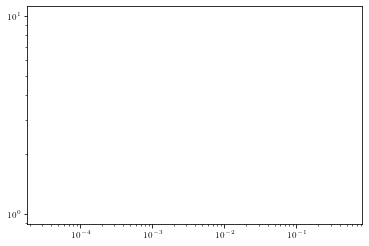

In [10]:
for Ri, R in enumerate(Rs):
    plt.hist(Qs[1,Ri,-1].C(1), bins=np.geomspace(3e-5,5e-1,100), color=colors[R], zorder=4-Ri);
    plt.yscale("log")
    plt.xscale("log")

## Network Measure L Scaling

In [39]:
def network_measure_Lscaling(QS, ICs, Rs, Ls, t0=None, ls="none", axs=None):
    tight_layout = False
    yticks = False
    if axs is None:
        fig, axs = plt.subplots(2,1, figsize=(4,6))
        tight_layout = True
        yticks = True
        
    RCs = np.zeros(len(Ls), dtype="object")
    RYs = np.zeros(len(Ls), dtype="object")
    lm=5
    for ICi, IC in enumerate(ICs):
        for Ri, R in enumerate(Rs):
            Cbars = []
            DYbars = []
            for Li, L in enumerate(Ls[:]):
                Q = Qs[ICi, Ri, Li]
                if t0 is None:
                    t0= int(Q.T/2)
                C = Q.C(1, save=True)[int(t0/Q.dt)::int(1/Q.dt)]
                Y = Q.Y(1, save=True)[int(t0/Q.dt)::int(1/Q.dt)]
                DY = Q.rolling(np.std, Y)
                Cbar = np.mean(C)
                print(L,Q.available_tasks)
                DYbar = np.mean(DY)
                Cbars.append(Cbar)
                DYbars.append(DYbar)
                if IC[0] == "R":
                    RCs[Li] += C / len(Rs)
                    RYs[Li] += Y/ len(Rs)
            if IC[0] != "R":
                axs[0].plot(Ls[:], Cbars, c=colors[R], marker="o", ms=3, lw=1, ls=ls)
                axs[0].set_yscale("log")
                #axs[0].set_xscale("log")
                axs[0].set_ylabel(names["Cavg"])

                axs[1].plot(Ls[:], DYbars, c=colors[R], marker="o", ms=3, lw=1, ls=ls)
                axs[1].set_yscale("log")
                #axs[1].set_xscale("log")
                
                axs[1].set_ylabel(names["DYavg"])
                axs[1].set_xlabel(names["size"])

    RDYbars = np.array([np.mean(Q.rolling(np.std, RY)) for RY in RYs])
    RCbars = np.array([np.mean(RC) for RC in RCs])
    axs[0].plot(Ls[:], RCbars, c="k", marker="o", ms=3, lw=1, ls=ls)
    axs[1].plot(Ls[:], RDYbars, c="k", marker="o",ms=3, lw=1, ls=ls)

    
    if not yticks:
        axs[0].set_yticklabels([])
        axs[1].set_yticklabels([])
    
    if tight_layout:
        plt.tight_layout()

6 ['C_1', 'C_2', 'MI_2', 'P_1', 'Y_1', 'Y_2', 'ebipartdata', 'params', 'rhoj', 'rhojk', 'sbipart_2', 'sbisect_1', 'sbisect_2', 'ts']
7 ['C_1', 'C_2', 'MI_1', 'MI_2', 'P_1', 'Y_1', 'Y_2', 'ebipartdata', 'params', 'rhoj', 'rhojk', 'sbipart_2', 'sbisect_1', 'sbisect_2', 'ts']
8 ['C_1', 'C_2', 'MI_2', 'P_1', 'Y_1', 'Y_2', 'ebipartdata', 'params', 'rhoj', 'rhojk', 'sbipart_2', 'sbisect_1', 'sbisect_2', 'ts']
9 ['C_1', 'C_2', 'MI_1', 'MI_2', 'P_1', 'Y_1', 'Y_2', 'ebipartdata', 'params', 'rhoj', 'rhojk', 'sbipart_2', 'sbisect_1', 'sbisect_2', 'ts']
10 ['C_1', 'C_2', 'P_1', 'Y_1', 'Y_2', 'ebipartdata', 'params', 'rhoj', 'rhojk', 'sbipart_2', 'sbisect_1', 'sbisect_2', 'ts']
11 ['C_1', 'C_2', 'P_1', 'Y_1', 'Y_2', 'bisect', 'ebipartdata', 'params', 'rhoj', 'rhojk', 'sbipart_2', 'sbisect_1', 'sbisect_2', 'ts']
12 ['C_1', 'C_2', 'P_1', 'Y_1', 'Y_2', 'bisect', 'ebipartdata', 'params', 'rhoj', 'rhojk', 'sbipart_2', 'sbisect_1', 'sbisect_2', 'ts']
13 ['C_1', 'C_2', 'P_1', 'Y_1', 'Y_2', 'bisect', 'ebip

13 ['C_1', 'C_2', 'Y_1', 'Y_2', 'bisect', 'ebipartdata', 'params', 'rhoj', 'rhojk', 'sbipart_2', 'sbisect_1', 'sbisect_2', 'ts']
14 ['C_1', 'C_2', 'MI_1', 'Y_1', 'Y_2', 'bisect', 'ebipartdata', 'params', 'rhoj', 'rhojk', 'sbipart_2', 'sbisect_1', 'sbisect_2', 'ts']
15 ['C_1', 'C_2', 'MI_1', 'Y_1', 'Y_2', 'bisect', 'ebipartdata', 'params', 'rhoj', 'rhojk', 'sbipart_2', 'sbisect_1', 'sbisect_2', 'ts']
16 ['C_1', 'C_2', 'Y_1', 'Y_2', 'bisect', 'ebipartdata', 'ebisectdata', 'params', 'rhoj', 'rhojk', 'sbipart_2', 'sbisect_1', 'sbisect_2', 'ts']
17 ['C_1', 'C_2', 'Y_1', 'Y_2', 'bisect', 'ebipartdata', 'params', 'rhoj', 'rhojk', 'sbipart_2', 'sbisect_1', 'sbisect_2', 'ts']
18 ['C_1', 'C_2', 'Y_1', 'Y_2', 'bisect', 'ebipartdata', 'params', 'rhoj', 'rhojk', 'sbipart_2', 'sbisect_1', 'sbisect_2', 'ts']
19 ['C_1', 'C_2', 'MI_1', 'P_1', 'Y_1', 'Y_2', 'bisect', 'ebipartdata', 'ebisectdata', 'params', 'rhoj', 'rhojk', 'sbipart_2', 'sbisect_1', 'sbisect_2', 'ts']
6 ['C_1', 'C_2', 'MI_2', 'P_1', 'Y_1

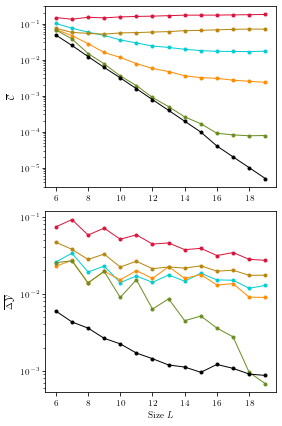

In [40]:
network_measure_Lscaling(Qs, ICs, Rs, Ls, ls="-")

## Network strength Distribution

In [47]:
Ls

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [13]:
zorders={6:1, 4:2, 26:3, 1:4, 14:5}
def network_strength_distribution(Qs, ICs, Rs, Li=-1, t0=None, ax=None, inset=True):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if inset:
        axins = ax.inset_axes([0.1, 0.15, 0.43, 0.3])
    Rhist = 0
    Rbins = np.logspace(np.log10(1e-5), np.log10(1e-4), 100)
    for ICi, IC in enumerate(ICs):
        for Ri, R in enumerate(Rs):
            Q = Qs[ICi, Ri, Li]
            if t0 is None:
                t0= int(Q.T/2)
            M = Q.MI(1, save=True)[int(t0/Q.dt)::int(1/Q.dt)].sum(axis=1).ravel()
            M = M[M>1e-10]
            if IC[0] != "R":
                mx = np.max(M)
                mn = np.min(M)
                hist, edges = np.histogram(M, density=True,
                    bins=np.logspace(np.log10(mn), np.log10(mx), 100))
                bins = edges[:-1] + np.diff(edges)/2
                mask = (hist*bins*M.size) > 75
                print(sum(mask))
                #mask = np.logical_and(mask, hist>0.5)
                hist = hist[mask]
                bins = bins[mask]
                if R == 6:
                    func, m, b = powerlaw_fit(bins, hist)
                ax.plot(bins, hist, color=colors[R], marker="o",
                        zorder=zorders[R], ms=1, lw=1, ls="none")
                if inset:
                    axins.plot(bins, hist, color=colors[R], marker="o",
                        zorder=zorders[R], ms=1, lw=1, ls="none")
            else:
                hist, edges = np.histogram(M, density=True, bins=Rbins)
                Rbinso = edges[:-1] + np.diff(edges)/2
                Rhist += hist / len(Rs)
                


    Rmask = (Rhist*Rbinso*M.size) > 75
    ax.plot(Rbinso[Rmask], Rhist[Rmask], marker="o", c="k", ms=1, lw=1, ls="none")

    fbins = np.geomspace(1.5,3.5, 100)
    #ax.plot(fbins, func(fbins), ls="--", c="k", lw=1, zorder=100)
    #fbins1 = np.geomspace(3e-5, 1e-0, 100)
    #fbins2 = np.geomspace(1e-2, 0.4, 100)
    #ax.plot(fbins1, 0.05*fbins1**(-2/3), ls="--", c="k", lw=1, zorder=100)
    #ax.plot(fbins2, 0.4/fbins2, ls="--", c="k", lw=1, zorder=100)
    
    #ax.text(8e-8, 20, f"slope:\n{round(m,2)}", fontsize=9)
    ax.set_yscale("log")
    ax.set_xscale("log")
    if inset:
        axins.set_yscale("log")
        Mijticks = [0, 1, 2, 3]
        probticks = [1e-2, 1e0, 1e2, 1e4]

        axins.set_xticks(Mijticks)
        axins.set_yticks(probticks)
        axins.set_yticklabels([])
        axins.tick_params(axis="both", direction="inout")
        axins.tick_params(axis="both", direction="inout")

    ax.set_xlabel("Node strength $g$")
    ax.set_ylabel("Prob. density")


51
97
84
88
95


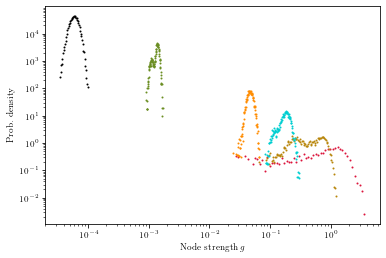

In [14]:
network_strength_distribution(Qs, ICs, Rs, Li=-1, inset=False)

38
88
85
79
74


/home/lhillber/.local/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


51
97
84
88
95


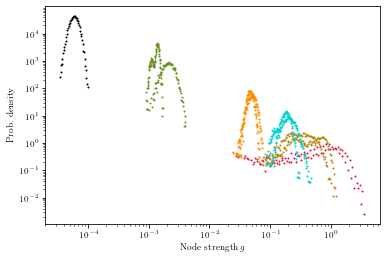

In [15]:
fig, ax = plt.subplots(1,1)
network_strength_distribution(Qs, ICs, Rs, Li=8, ax=ax, inset=False)
network_strength_distribution(Qs, ICs, Rs, Li=-1, ax=ax, inset=False)

## Network visualizations

In [16]:
reload(figures)
from figures import draw_MI
from matplotlib.patches import Patch
def netviz(QS, ICs, Rs, Rorder=None, Li=-1, t0=455, axs=None, statestrs=["R"]):
    if axs is None:
        fig, axs = plt.subplots(1,len(Rs)+len(statestrs), figsize=(8, 4))
    legend_els = []
    for ICi, IC in enumerate(ICs):
        for axi, R in enumerate(Rorder):
            Ri = Rs.index(R)
            if IC[0] != "R":
                legend_els += [Patch(facecolor=colors[R], edgecolor=None, label=names[R])]
                Q = Qs[ICi, Ri, Li]
                M = Q.MI(1)[int(t0/Q.dt)]
                draw_MI(M, ax=axs[axi], layout="spring")
                
    
    for axii, state in enumerate(statestrs):
        legend_els += [Patch(facecolor=colors["R"], edgecolor=None, label=names["R"])]
        M = ms.get_MI_from_state(make_state(Ls[Li], state), order=1)
        draw_MI(M, ax=axs[len(Rs)+axii], layout="spring")
    
    
    axs[0].legend(handles=legend_els,
                 ncol=6,
                 columnspacing=5.4,
                 frameon=False,
                 loc="lower left",
                 bbox_to_anchor=(0.1, -0.57, 7, 1),
                 bbox_transform=axs[0].transAxes,
                 handlelength=0.71,
                 handletextpad=0.1)
        

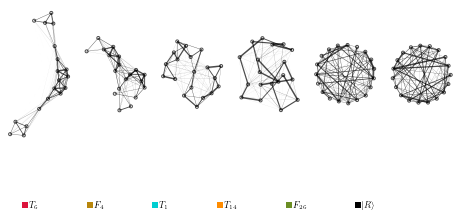

In [17]:
netviz(Qs, ICs, Rs, Rorder=[6,4,1,14,26])

## Compiled Figure 3

51
97
84
88
95


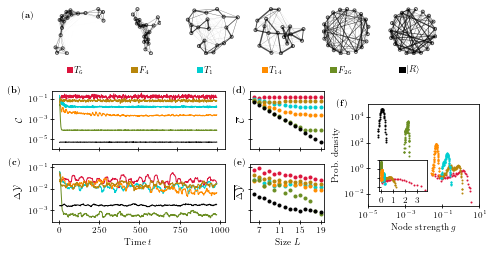

In [24]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(2*3.375, 3.55))
gs1 = GridSpec(1, 6)
gs1.update(left=0.1, right=0.9, bottom=0.79, top=0.98)

netviz_axs = [fig.add_subplot(gs1[0, i]) for i in range(6)]

gs2 = GridSpec(2, 3)
gs2.update(left=0.1, right=0.66, bottom=0.14, top=0.65, wspace=0.35, hspace=0.25)

gs3 = GridSpec(1, 1)
gs3.update(left=0.75, right=0.98, bottom=0.2, top=0.6)

timeseries_axs = [fig.add_subplot(gs2[0, 0:2]), fig.add_subplot(gs2[1, 0:2])]
Lscaling_axs = [fig.add_subplot(gs2[0, 2:3]), fig.add_subplot(gs2[1, 2:3])]
netdist_ax = fig.add_subplot(gs3[:, :])
netviz(Qs, ICs, Rs, Rorder=[6,4,1,14,26],t0=455, axs=netviz_axs)
network_measure_timeseries(Qs, ICs, Rs, axs=timeseries_axs)
network_measure_Lscaling(Qs, ICs, Rs, Ls, axs=Lscaling_axs)
network_strength_distribution(Qs, ICs, Rs, ax=netdist_ax)

Cylim = [1e-6, 0.6]
Yylim = [3e-4, 0.15]
Cyticks = [1e-5, 1e-3, 1e-1]
Yyticks = [1e-3, 1e-2, 1e-1]
timeticks = [0, 250, 500, 750, 1000]
Lticks = [7, 11, 15, 19]

Mijticks = [1e-5, 1e-3, 1e-1, 1e1]
probticks = [1e-2, 1e0, 1e2, 1e4]

netdist_ax.set_xticks(Mijticks)
netdist_ax.set_yticks(probticks)
netdist_ax.tick_params(axis="both", direction="inout")
netdist_ax.tick_params(axis="both", direction="inout")

timeseries_axs[1].set_xticks(timeticks)
timeseries_axs[0].set_xticks(timeticks)
Lscaling_axs[0].set_xticks(Lticks)
Lscaling_axs[1].set_xticks(Lticks)
Lscaling_axs[0].yaxis.labelpad = -1
Lscaling_axs[1].yaxis.labelpad = -1
for axs in [timeseries_axs, Lscaling_axs]:
    axs[0].set_yticks(Cyticks)
    axs[0].set_ylim(Cylim)
    axs[0].minorticks_off()
    axs[0].set_xticklabels([])
    axs[0].tick_params(axis="both", direction="inout")
    axs[1].minorticks_off()
    axs[1].set_yticks(Yyticks)
    axs[1].set_ylim(Yylim)
    axs[1].tick_params(axis="both", direction="inout")

lettering(netviz_axs[0], -0.5, 0.8, 0)
lettering(timeseries_axs[0], -0.22, 1.0, 1)
lettering(timeseries_axs[1], -0.22, 1.0, 2)
lettering(Lscaling_axs[0], -0.155, 1.0, 3)
lettering(Lscaling_axs[1], -0.155, 1.0, 4)
lettering(netdist_ax, -0.23, 1.0, 5)

plt.savefig("figures/figure3_V13.pdf")